In [1]:
!git clone https://github.com/Mike030668/Project_glass.git -q

In [2]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  import os
  os.chdir('/content/Project_glass')
  os.getcwd()

else:
  print('Not running on CoLab')

Running on CoLab


In [25]:
from prepare_data.conts_predtrend import WIND_SED, RATIO, DEPTH, PREDICT_LAG, BATCH_SIZE
from prepare_data.constants import GLASS_COLS, FUTURE, MAIN_COLS
from prepare_data.trend_utils import Gaussignal, Segment
from prepare_data.utils import split_sequence
from utils.estimation import confusion_matrix

import numpy as np # библиотека нампи
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import joblib
import pandas as pd # библиотека пандас
import tensorflow as tf           # библиотека машинного обучения

# load prepared train data

data prepared with vcs note makedata_vsc.ipynb

In [6]:
x_train_sc = np.load("./predtrend/x_train_sc.npy")
x_val_sc = np.load("./predtrend/x_val_sc.npy")
y_train_sc = np.load("./predtrend/y_train_sc.npy")
y_val_sc = np.load("./predtrend/y_val_sc.npy")
y_data = np.load("./predtrend/y_data.npy")

In [7]:
from construct_model.make_models import baseline, model_trendpath_colab

model= baseline(input_shape = x_val_sc.shape[1:],
                    pred_num = PREDICT_LAG,
                    activ_hid_1="tanh",
                    activ_hid_2 = 'tanh',
                    activ_out = "tanh",
                    depth= DEPTH)


In [8]:
# понижение шага
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8,
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

path_model = model_trendpath_colab

# Сохранение модели
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
                        filepath = path_model,
                        #save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True
                        )
# оптимизатор
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.Huber() #.MSE #
model.compile(optimizer = optimizer, loss = loss, metrics=['mae'])

In [9]:
# обучение модели вашей
history = model.fit(x_train_sc, y_train_sc,                  # генератор данных для обучения
                    validation_data=(x_val_sc, y_val_sc), # генератор данных для проверки
                    batch_size=BATCH_SIZE,
                    epochs = 200,
                    callbacks=[early_stopping, reduce_lr, checkpoint],
                    verbose = 1)

Epoch 1/200
35/35 [==============================] - 23s 411ms/step - loss: 0.1420 - mae: 0.4233 - val_loss: 0.1429 - val_mae: 0.4418 - lr: 0.0010
Epoch 2/200
35/35 [==============================] - 10s 293ms/step - loss: 0.0901 - mae: 0.3312 - val_loss: 0.1401 - val_mae: 0.4310 - lr: 0.0010
Epoch 3/200
35/35 [==============================] - 1s 17ms/step - loss: 0.0639 - mae: 0.2782 - val_loss: 0.1551 - val_mae: 0.4616 - lr: 0.0010
Epoch 4/200
35/35 [==============================] - 1s 16ms/step - loss: 0.0462 - mae: 0.2354 - val_loss: 0.1474 - val_mae: 0.4508 - lr: 0.0010
Epoch 5/200
33/35 [===========================>..] - ETA: 0s - loss: 0.0375 - mae: 0.2097
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
35/35 [==============================] - 1s 16ms/step - loss: 0.0374 - mae: 0.2096 - val_loss: 0.1655 - val_mae: 0.4730 - lr: 0.0010
Epoch 6/200
35/35 [==============================] - 1s 15ms/step - loss: 0.0304 - mae: 0.1894 - val_loss: 0.1548 - va

In [10]:
pred = model.predict(x_val_sc, verbose=False)
pred_signal = np.squeeze(pred)

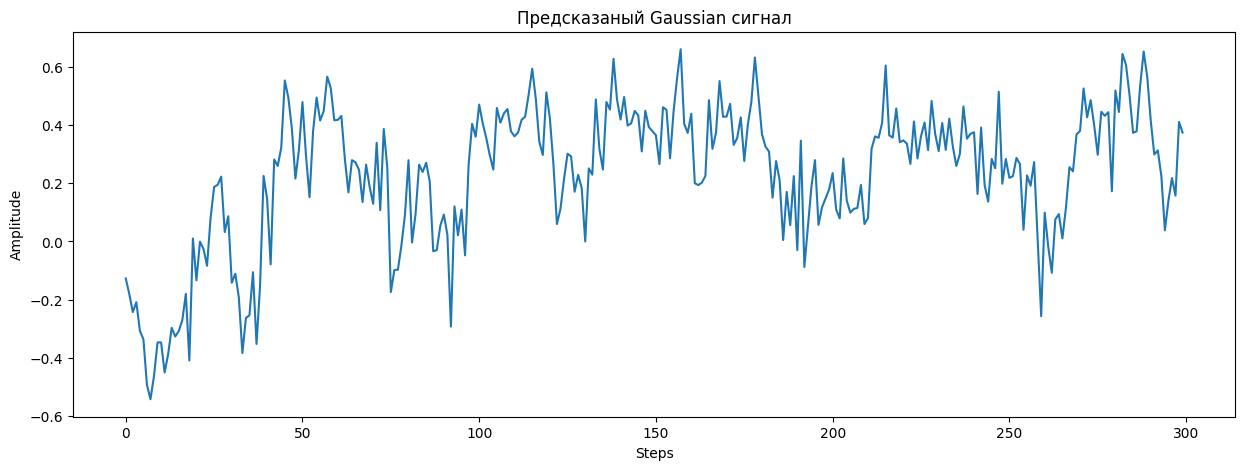

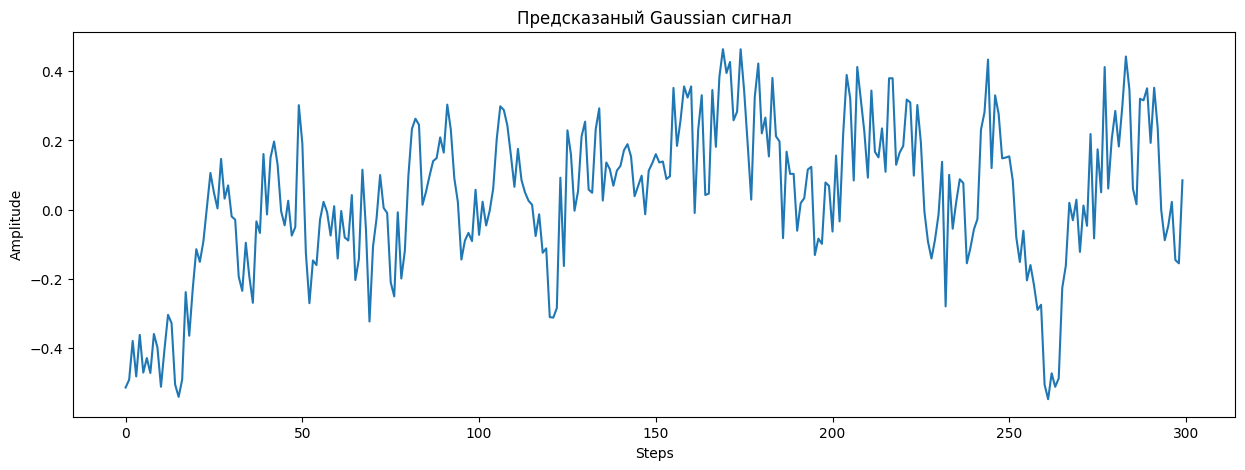

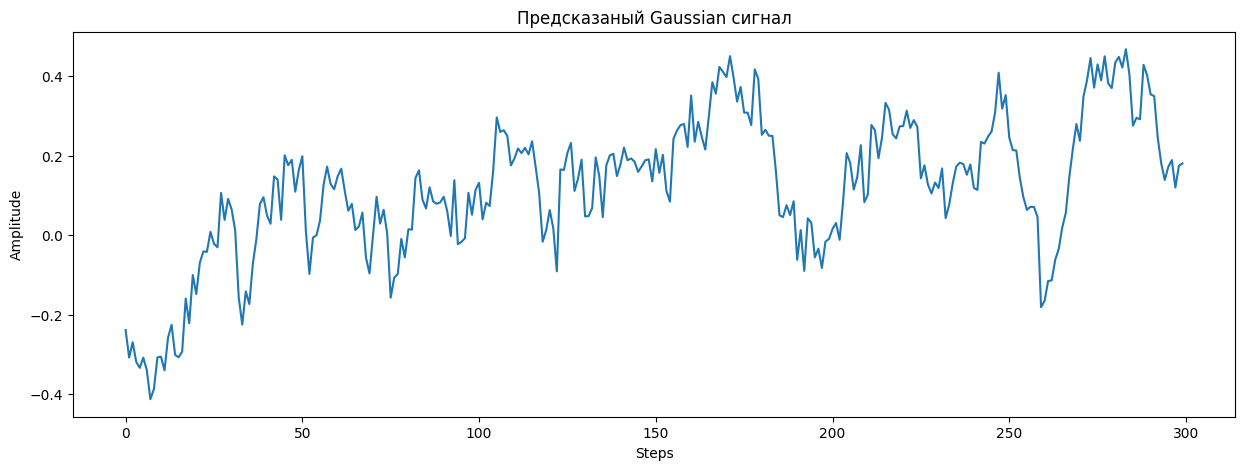

In [11]:
gd = Gaussignal(y_val_sc[:,0])
gd.plot_gausdata(100, 400, pred_signal[:,0], title="pred")
gd.plot_gausdata(100, 400, pred_signal[:,4], title="pred")
gd.plot_gausdata(100, 400, pred_signal.mean(1), title="pred")

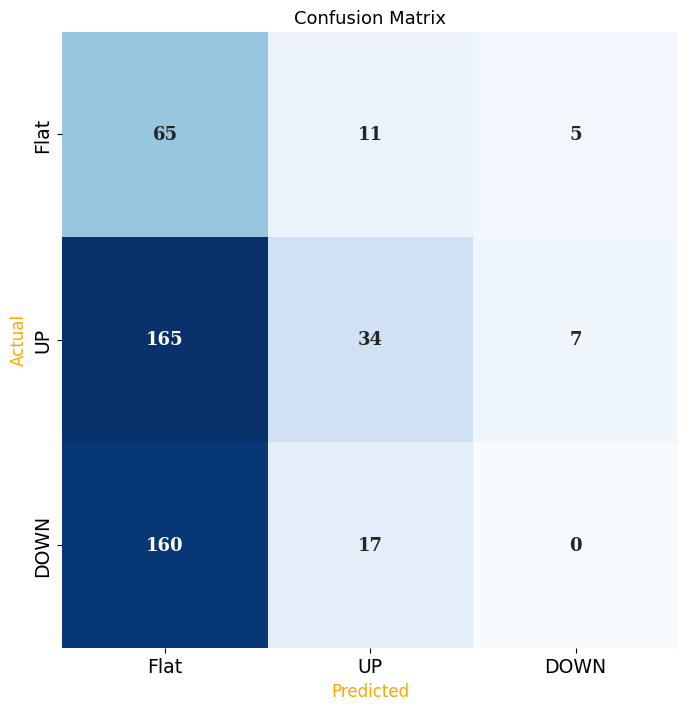

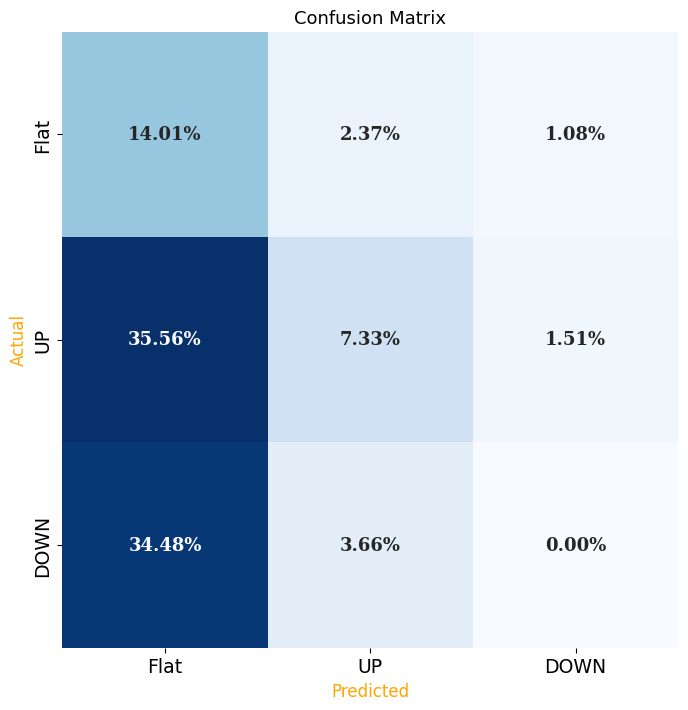

In [51]:
# устанавливаем переход от ожидания к действию
TRESH_UP = 0.3
TRESH_DOWN = -0.3
VAL_LEN = 500
lag = 1
#test_signal = pred_signal[:,lag]
test_signal = pred_signal.mean(1)
# переведем сигнал от нейронки в класс действия
y_pred = np.zeros(pred_signal.shape[0])
y_pred[test_signal > TRESH_UP] = 1
y_pred[test_signal < TRESH_DOWN] = 2

# переведем сигнал от разметки  в класс действия
y_true_ = y_data[-1-VAL_LEN+DEPTH+lag:-PREDICT_LAG+lag]
y_true = np.zeros(y_true_.shape[0])
y_true[y_true_==1] = 1
y_true[y_true_== -1] = 2

# строим матрицу ошибок
confusion_matrix(y_true, y_pred, labels=['Flat', 'UP', 'DOWN'], figsize=(8,8))
confusion_matrix(y_true, y_pred, labels=['Flat', 'UP', 'DOWN'], normalize='all', figsize=(8,8))

## Тест модели на TEST данных

## Готовим производные данных

In [31]:
all_data = pd.read_csv("/content/Project_glass/stock_data/BTCUSDT_1 _min.csv",
                       index_col=0, parse_dates=True )
print(f'Размер данных {all_data.shape}')

TEST_SIZE = 1500 # для теста откусим последние test_size значений
# Тестовая выборка для симуляции торговли в реальном времени
print(f'Тестовый датасет')
TEST_DATASET = all_data[FUTURE: FUTURE + TEST_SIZE]
print(TEST_DATASET.shape)


Размер данных (8317, 54)
Тестовый датасет
(1500, 54)


### Готовим данные из df_test

In [32]:
# колонки для тренировочной выборки
TRAIN_COLUMNS = MAIN_COLS + GLASS_COLS
GLASS = len(GLASS_COLS)

X_MAIN_SCALER = joblib.load("/content/Project_glass/predtrend/x_main_scailer.save")
X_GLASS_SCALER = joblib.load("/content/Project_glass/predtrend/x_glass_scailer.save")


x_test = all_data.iloc[FUTURE-PREDICT_LAG-DEPTH+1: FUTURE + TEST_SIZE][TRAIN_COLUMNS].values

x_test_sc = np.zeros_like(x_test)
x_test_sc[:,:-GLASS] = X_MAIN_SCALER.transform(x_test[:,:-GLASS])  # трансформируем x_train
x_test_sc[:,-GLASS:] = X_GLASS_SCALER.transform(x_test[:,-GLASS:])  # трансформируем x_train


print(x_test_sc.shape)
x_test_sc[0]

(1536, 54)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array([0.40089549, 0.37504176, 0.44774601, 0.39521677, 0.0298172 ,
       0.68662993, 0.01839537, 0.05194977, 0.43837447, 0.07743754,
       0.03212242, 0.80707965, 0.81132075, 0.18867925, 0.8       ,
       0.82460414, 0.17539586, 0.39956851, 0.28321618, 0.14191481,
       0.        , 0.        , 0.03700431, 0.00745415, 0.03652966,
       0.00663946, 0.03916718, 0.01172088, 0.06230337, 0.04051033,
       0.03054307, 0.0354226 , 0.04561684, 0.06391786, 0.10168263,
       0.05378194, 0.12621431, 0.08920036, 0.12349503, 0.01738239,
       0.01608167, 0.07496685, 0.05234175, 0.02497706, 0.11997376,
       0.01923063, 0.0140643 , 0.14005559, 0.24357494, 0.21492836,
       0.23465609, 0.11423777, 0.14105165, 0.27633278])

In [33]:
# Формирование выборок для обучения нейросети
x_test_sc = split_sequence(x_test_sc, DEPTH, PREDICT_LAG)
x_test_sc.shape

(1500, 32, 54)

In [34]:
pred_test = model.predict(x_test_sc, verbose=False)
pred_test_signal = np.squeeze(pred_test)

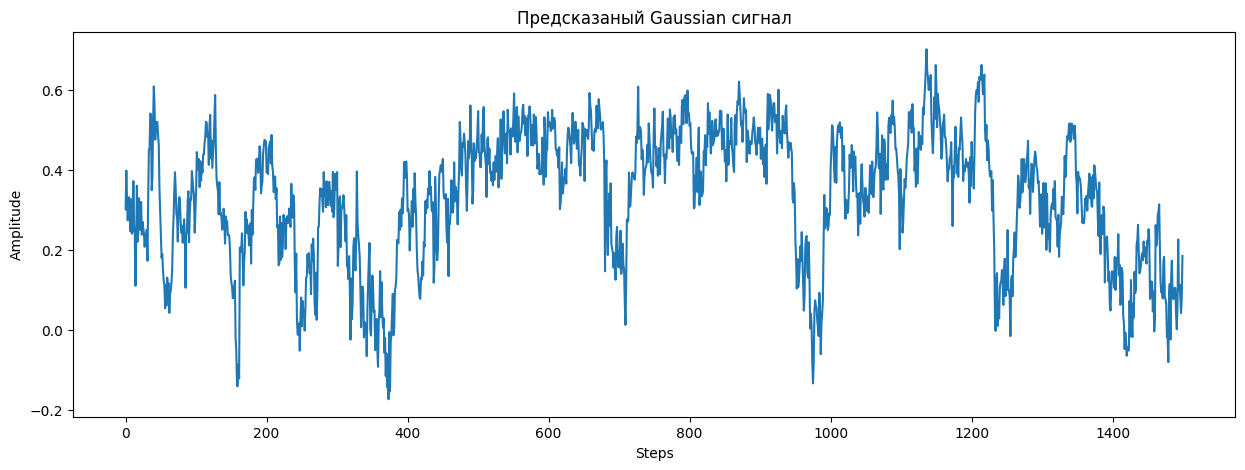

In [35]:
gd.plot_gausdata(0, len(pred_test_signal), pred_test_signal.mean(1), title="pred")

In [48]:
# устанавливаем переход от ожидания к действию
TRESH_UP = 0.3
TRESH_DOWN = -0.3
# переведем сигнал от нейронки в класс действия
trend_test = np.zeros(pred_test_signal.shape[0])
trend_test[pred_test_signal.mean(1) > TRESH_UP] = 1
trend_test[pred_test_signal.mean(1) < TRESH_DOWN] = 2

TEST_DATASET["Trend"] = trend_test

<ipython-input-48-ab54e2392f91>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEST_DATASET["Trend"] = trend_test


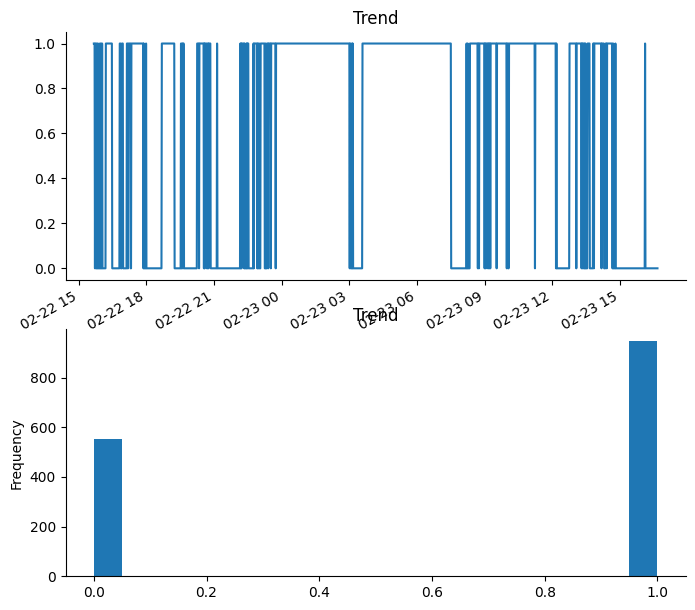

In [49]:
seg = Segment()

seg.plot_segmented(TEST_DATASET['Trend'])

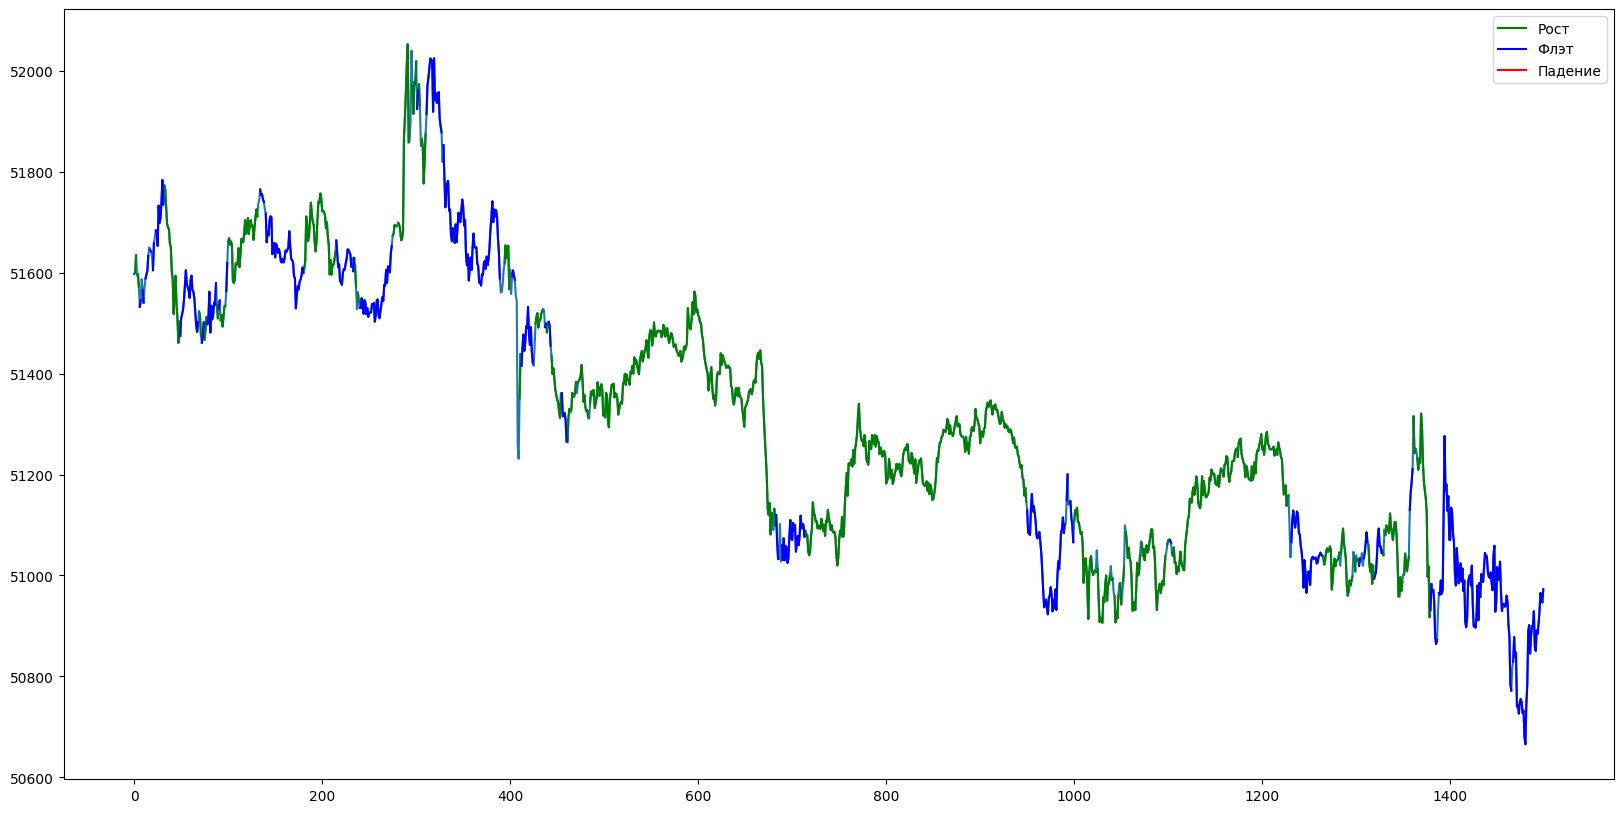

In [50]:
start = 0  # начало фрагмента
end = TEST_DATASET.shape[0]    # окончание фрагмента
seg.plot_trend(TEST_DATASET, start, end)